In [1]:
import keras
from keras.models import Model,Sequential
from keras.layers import Input,Dense, Dropout, Activation, Flatten, Reshape, Conv2D, MaxPooling2D, AveragePooling2D
from keras import regularizers
from keras.losses import mean_squared_error
from keras import losses
import matplotlib.patches as patches
import numpy as np
import dicom
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/Users/attia/Desktop/Work/workenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


The second step of the algorithm is to train a stacked Auto-encoder in order to get the binary mask of the left ventricule inferred shape within the ROI (region of interest output of CNN). It is performed in two steps : pre-training then fine-tuning.

## Open results from CNN

Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)


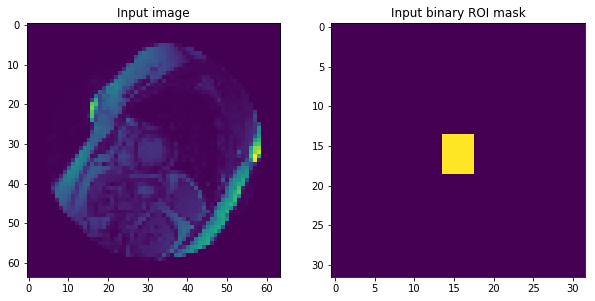

Size for each layer :
Layer, Input Size, Output Size
Conv2D_1 (None, 64, 64, 1) (None, 54, 54, 100)
Average_Pooling2D_1 (None, 54, 54, 100) (None, 9, 9, 100)
Reshape_1 (None, 9, 9, 100) (None, 1, 8100)
Dense_1 (None, 1, 8100) (None, 1, 1024)
Reshape_2 (None, 1, 1024) (None, 1, 32, 32)
Epoch 1/20
495/495 [==============================] - 8s 16ms/step - loss: 0.1838 - acc: 0.2115
Epoch 2/20
495/495 [==============================] - 6s 12ms/step - loss: 0.1038 - acc: 0.1429
Epoch 3/20
495/495 [==============================] - 6s 12ms/step - loss: 0.0783 - acc: 0.0616
Epoch 4/20
495/495 [==============================] - 5s 11ms/step - loss: 0.0621 - acc: 0.0838
Epoch 5/20
495/495 [==============================] - 5s 11ms/step - loss: 0.0518 - acc: 0.0856
Epoch 6/20
495/495 [==============================] - 5s 11ms/step - loss: 0.0460 - acc: 0.0728
Epoch 7/20
495/495 [==============================] - 7s 14ms/step - loss: 0.0407 - acc: 0.0741
Epoch 8/20
495/495 [======================

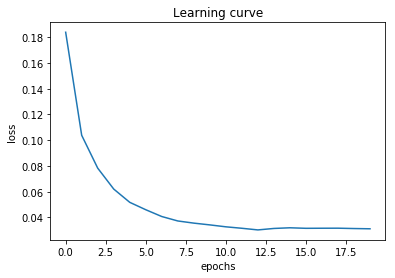

Stored 'y_pred' (ndarray)


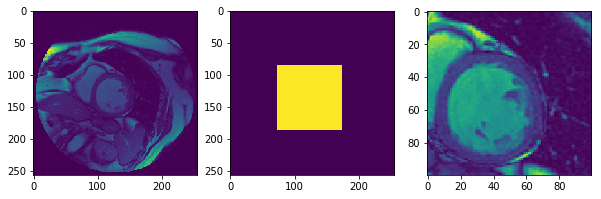

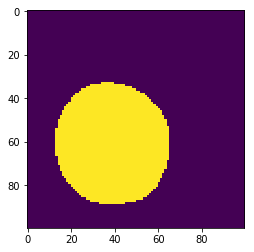

In [2]:
%run 'CNN.ipynb'

In [3]:
%store -r y_pred

In [4]:
def open_data_AE(y_pred):
    """
    Open dataset from the output of the CNN and
    unroll it as 64*64 = vector of 4096 elements
    :param y_pred: CNN output
    :return: input AE, output
    """
    input_AE = []
    contour_experts = []
    for j in range(y_pred.shape[0]):
        in_AE = cv2.resize(compute_roi_pred(y_pred, j, roi_shape=32)[0],(64 , 64))
        contour = cv2.resize(compute_roi_pred(y_pred, j)[2], (64,64), interpolation = cv2.INTERSECT_NONE)
        input_AE.append(in_AE)
        contour_experts.append(contour)
    return np.array(input_AE).reshape((-1, 64*64)), np.array(contour_experts).reshape((-1, 64*64))

## Stacked auto-encoder : Construction of 3 autoencoder 

In [5]:
def customized_loss(y_true, y_pred, alpha=0.0001, beta=3):
    """
    Create a customized loss for the stacked AE.
    Linear combination of MSE and KL divergence.
    """
    #customize your own loss components
    loss1 = losses.mean_absolute_error(y_true, y_pred)
    loss2 = losses.kullback_leibler_divergence(y_true, y_pred)
    #adjust the weight between loss components
    return (alpha/2) * loss1 + beta * loss2

In [6]:
X_train, Y_train = open_data_AE(y_pred)
X_train.shape, Y_train.shape

((495, 4096), (495, 4096))

### Model 1 : ROI + H1

In [7]:
def model1(X_train, get_history=False, verbose=0, param_reg=3*0.001):
    """
    First part of the stacked AE.
    Train the AE on the ROI input images.
    :param X_train: ROI input image
    :param get_history: boolean to return the loss history
    :return: encoded ROI image
    """
    autoencoder_0 = Sequential()
    encoder_0 = Dense(input_dim=4096, units=100, kernel_regularizer=regularizers.l2(param_reg))
    decoder_0 = Dense(input_dim=100, units=4096, kernel_regularizer=regularizers.l2(param_reg))
    autoencoder_0.add(encoder_0)
    autoencoder_0.add(decoder_0)
    autoencoder_0.compile(loss= customized_loss,optimizer='adam', metrics=['accuracy'])
    h = autoencoder_0.fit(X_train, X_train, epochs=100, verbose=verbose)

    temp_0 = Sequential()
    temp_0.add(encoder_0)
    temp_0.compile(loss= customized_loss, optimizer='adam', metrics=['accuracy'])
    encoded_X = temp_0.predict(X_train, verbose=0)
    if get_history:
        return h.history['loss'], encoded_X, encoder_0
    else:
        return encoded_X, encoder_0

In [8]:
encoded_X, encoder_0 = model1(X_train)

### Model 2 : H1 + H2

In [9]:
def model2(encoded_X, get_history=False, verbose=0, param_reg=3*0.001):
    """
    Second part of the stacked AE.
    :param X_train: encoder ROI image
    :param get_history: boolean to return the loss history
    :return: encoding layer
    """
    autoencoder_1 = Sequential()
    encoder_1 = Dense(input_dim=100, units=100, kernel_regularizer=regularizers.l2(param_reg))
    decoder_1 = Dense(input_dim=100, units=100, kernel_regularizer=regularizers.l2(param_reg))
    autoencoder_1.add(encoder_1)
    autoencoder_1.add(decoder_1)
    autoencoder_1.compile(loss= customized_loss, optimizer='adam', metrics=['accuracy'])
    h = autoencoder_1.fit(encoded_X, encoded_X, epochs=100, verbose=verbose)

    temp_0 = Sequential()
    temp_0.add(encoder_0)
    temp_0.compile(loss= customized_loss, optimizer='adam', metrics=['accuracy'])
    encoded_X = temp_0.predict(X_train, verbose=0)
    if get_history:
        return h.history['loss'], encoder_1
    else:
        return encoder_1

In [10]:
encoder_1 = model2(encoded_X)

### Model 3 : H1 + Annotated contours

In [12]:
def model3(X_train, Y_train, encoder_0, encoder_1, init='zero',
           get_history=False, verbose=0, param_reg=3*0.001):
    """
    Last part of the stacked AE.
    :param X_train: ROI input image
    :param init: set the initial kernel weights (None for uniform)
    :param get_history: boolean to return the loss history
    :return: final model
    """
    model = Sequential()
    model.add(encoder_0)
    model.add(encoder_1)
    model.add(Dense(input_dim=100, units=4096, kernel_initializer=init, kernel_regularizer=regularizers.l2(param_reg)))
    model.compile(optimizer = 'adam', loss = "MSE", metrics=['accuracy'])
    h = model.fit(X_train, Y_train, epochs=20, verbose=verbose)
    if get_history:
        return h.history['loss'], model
    else:
        return model

In [15]:
h, model = model3(X_train, Y_train, encoder_0, encoder_1, get_history=True)

Text(0.5,0,'epochs')

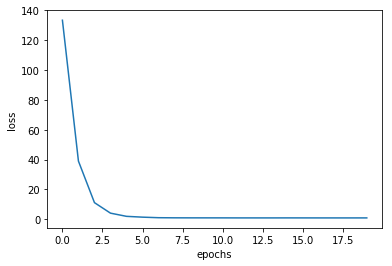

In [16]:
plt.plot(range(len(h)), h)
plt.ylabel('loss')
plt.xlabel('epochs')

### Prediction

In [20]:
def prediction_plot(X, model, idx=None):
    """
    Compute the Inferred shape binary mask using the trained stacked AE model
    :param X: dataset to predict
    :param model: trained AE model
    :param idx: index of the particular picture to return
    :return: inferred shape binary mask, infered shape on the MR image
    """
    if not idx:
        idx= np.random.randint(len(X))
    contours = model.predict(X)
    contour = contours[idx].reshape((64,64))
    # thresholding
    binary = cv2.threshold(contour, 0, 1, cv2.INTERSECT_NONE)
    return binary[1], binary[1]*X[idx].reshape(64,64), idx

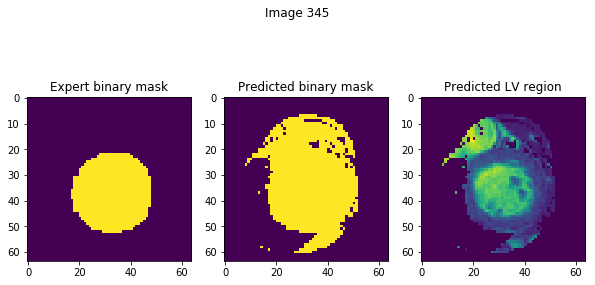

In [28]:
f, ax = plt.subplots(ncols=3, figsize=(10,5))
bin_mask, img, idx = prediction_plot(X_train, model)
ax[0].imshow(Y_train[idx].reshape((64,64)))
ax[0].set_title('Expert binary mask')
ax[1].imshow(bin_mask)
ax[1].set_title('Predicted binary mask')
ax[2].imshow(img)
ax[2].set_title('Predicted LV region')
_ = plt.suptitle('Image %s' % idx)

In [39]:
Y_pred[15:20, 15:20]

array([[ 0.,  0.,  1.,  1.,  1.],
       [ 0.,  1.,  1.,  0.,  1.],
       [ 0.,  1.,  1.,  0.,  1.],
       [ 1.,  0.,  1.,  1.,  1.],
       [ 0.,  1.,  1.,  1.,  1.]], dtype=float32)

## Metrics

In [36]:
idx = 345
Y_true = Y_train[345].reshape((64,64))
Y_pred = prediction_plot(X_train, model, idx=345)[0]

$A_{a} : \text{predicted contour}$  
$A_{m} : \text{manual contour}$

**Dice metric**  
Measuring the contour overlap   
$ QS = \frac{2 |A_{a} \bigcap A_{m}|}{|A_{a}|+|A_{m}|} $

** Conformity coefficient**  
Measuring the  ratio of the number of mis-segmented pixels  
$ CC = \frac{3DM-2}{DM} $

In [58]:
def dice_metric(X, Y):
    return np.sum(X[Y==1])*2.0 / (np.sum(X) + np.sum(Y))

def conformity_coefficient(X, Y):
    return (3*dice_metric(X,Y)-2)/dice_metric(X,Y)

In [59]:
dice_metric(Y_pred, Y_true), conformity_coefficient(Y_pred, Y_true)

(0.70360360360360363, 0.15749039692701661)